# Phage Quality vs Phage Length

This builds off the old `phage_lengths_moving_average` notebook

In [1]:
import os
import sys

import re 

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
from scipy.stats import pearsonr
from scipy.signal import find_peaks

from sklearn.linear_model import LinearRegression
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import subprocess
import gzip

# Read the CheckV data

See also the `checkv` notebook.

In [2]:
use_small_data = False
if use_small_data:
    checkv = pd.read_csv("../small_data/checkv.tsv.gz", compression='gzip', header=0, delimiter="\t")
else:
    checkv = pd.read_csv("../data/checkv.tsv.gz", compression='gzip', header=0, delimiter="\t")
checkv = checkv.rename(columns={"BASE": "Contig"})
checkv

,Contig,contig_id,contig_length,gene_count,viral_genes,host_genes,checkv_quality,miuvig_quality,completeness
0,GCA_000003135.1_ASM313v1_genomic.gbff.gz,GG666849.1_PP1,20352,30,0,2,Not-determined,Genome-fragment,NaN
1,GCA_000003135.1_ASM313v1_genomic.gbff.gz,GG666854.1_PP2,28564,28,1,14,Low-quality,Genome-fragment,35.35
2,GCA_000003645.1_ASM364v1_genomic.gbff.gz,CM000714.1_PP1,40297,55,14,9,Medium-quality,Genome-fragment,53.01
3,GCA_000003925.1_ASM392v1_genomic.gbff.gz,CM000742.1_PP1,21020,21,0,21,Not-determined,Genome-fragment,NaN
4,GCA_000003925.1_ASM392v1_genomic.gbff.gz,CM000742.1_PP2,17449,20,1,12,Low-quality,Genome-fragment,9.46
...,...,...,...,...,...,...,...,...,...
584931,GCA_008358225.1_PDT000582431.1_genomic.gbff.gz,AAKGOK010000032.1_PP4,12720,12,1,4,Low-quality,Genome-fragment,19.52
584932,GCA_008358225.1_PDT000582431.1_genomic.gbff.gz,AAKGOK010000039.1_PP5,39588,36,27,0,Medium-quality,Genome-fragment,61.44
584933,GCA_008358225.1_PDT000582431.1_genomic.gbff.gz,AAKGOK010000047.1_PP6,7894,15,1,3,Low-quality,Genome-fragment,4.37
584934,GCA_008358225.1_PDT000582431.1_genomic.gbff.gz,AAKGOK010000058.1_PP7,17896,18,0,10,Not-determined,Genome-fragment,NaN


In [3]:
acccol = 'ncbi_genbank_assembly_accession'
def get_acc_name(x):
    regexp = re.compile('(\w+\.\d+)_([\w\.\-]+)_genomic.gbff.gz')
    m = regexp.match(x)
    if not m:
        sys.stderr.write(f"WARNING: Regexp did not match {x}\n")
        return (None, None)
    return list(m.groups())

checkv = pd.concat([pd.DataFrame.from_records(checkv['Contig'].apply(get_acc_name), columns=[acccol, 'Name']), checkv], axis=1)
checkv

,ncbi_genbank_assembly_accession,Name,Contig,contig_id,contig_length,gene_count,viral_genes,host_genes,checkv_quality,miuvig_quality,completeness
0,GCA_000003135.1,ASM313v1,GCA_000003135.1_ASM313v1_genomic.gbff.gz,GG666849.1_PP1,20352,30,0,2,Not-determined,Genome-fragment,NaN
1,GCA_000003135.1,ASM313v1,GCA_000003135.1_ASM313v1_genomic.gbff.gz,GG666854.1_PP2,28564,28,1,14,Low-quality,Genome-fragment,35.35
2,GCA_000003645.1,ASM364v1,GCA_000003645.1_ASM364v1_genomic.gbff.gz,CM000714.1_PP1,40297,55,14,9,Medium-quality,Genome-fragment,53.01
3,GCA_000003925.1,ASM392v1,GCA_000003925.1_ASM392v1_genomic.gbff.gz,CM000742.1_PP1,21020,21,0,21,Not-determined,Genome-fragment,NaN
4,GCA_000003925.1,ASM392v1,GCA_000003925.1_ASM392v1_genomic.gbff.gz,CM000742.1_PP2,17449,20,1,12,Low-quality,Genome-fragment,9.46
...,...,...,...,...,...,...,...,...,...,...,...
584931,GCA_008358225.1,PDT000582431.1,GCA_008358225.1_PDT000582431.1_genomic.gbff.gz,AAKGOK010000032.1_PP4,12720,12,1,4,Low-quality,Genome-fragment,19.52
584932,GCA_008358225.1,PDT000582431.1,GCA_008358225.1_PDT000582431.1_genomic.gbff.gz,AAKGOK010000039.1_PP5,39588,36,27,0,Medium-quality,Genome-fragment,61.44
584933,GCA_008358225.1,PDT000582431.1,GCA_008358225.1_PDT000582431.1_genomic.gbff.gz,AAKGOK010000047.1_PP6,7894,15,1,3,Low-quality,Genome-fragment,4.37
584934,GCA_008358225.1,PDT000582431.1,GCA_008358225.1_PDT000582431.1_genomic.gbff.gz,AAKGOK010000058.1_PP7,17896,18,0,10,Not-determined,Genome-fragment,NaN


# Filter the data

We select either High-quality or Complete genomes and the phage length

In [4]:
df = checkv[(checkv['checkv_quality'] == 'High-quality') | (checkv['checkv_quality'] == 'Complete')][['ncbi_genbank_assembly_accession', 'contig_length', 'checkv_quality']]
df.head()

,ncbi_genbank_assembly_accession,contig_length,checkv_quality
5,GCA_000003925.1,67074,High-quality
9,GCA_000003955.1,39088,High-quality
20,GCA_000006665.1,21819,High-quality
24,GCA_000006665.1,58311,High-quality
26,GCA_000006665.1,126062,High-quality


# Plot the moving averages

We use the moving averages and then find local peaks

Text(0.5, 1.0, 'High Quality Prophage Predictions')

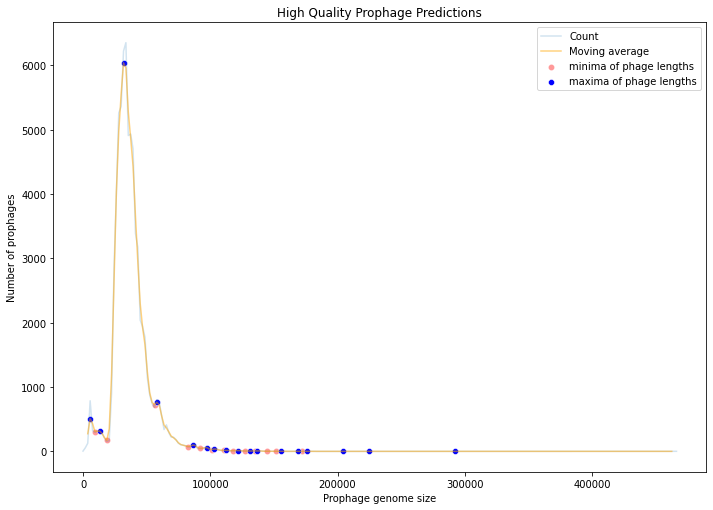

In [5]:
numBins=250
windowLength=5

count, division = np.histogram(df['contig_length'], bins=numBins)

np.max(division)        # Get histogram bin width
histogramBinSize = np.max(division)/numBins

hf = pd.DataFrame(count, columns=['Count'])
hf.index *= histogramBinSize

                        # Moving average
hf['ma'] = hf['Count'].rolling(windowLength, win_type='hanning', center=True).mean()

                        # Find local peaks
hf['min'] = hf.ma[(hf.ma.shift(1) > hf.ma) & (hf.ma.shift(-1) > hf.ma)]
hf['max'] = hf.ma[(hf.ma.shift(1) < hf.ma) & (hf.ma.shift(-1) < hf.ma)]

hf['min3'] = hf.ma[
    (hf.ma.shift(1) > hf.ma) &
    (hf.ma.shift(2) > hf.ma) &
    (hf.ma.shift(3) > hf.ma) &
    (hf.ma.shift(-3) > hf.ma) &
    (hf.ma.shift(-2) > hf.ma) &
    (hf.ma.shift(-1) > hf.ma)
    ]
hf['max3'] = hf.ma[
    (hf.ma.shift(1) < hf.ma) & 
    (hf.ma.shift(2) < hf.ma) & 
    (hf.ma.shift(3) < hf.ma) & 
    (hf.ma.shift(-3) < hf.ma) & 
    (hf.ma.shift(-2) < hf.ma) & 
    (hf.ma.shift(-1) < hf.ma)
    ]

hf['max4'] = hf.ma[(hf.ma > (hf['ma'].rolling(20, center=True).mean() + (1 * hf['ma'].rolling(20, center=True).std())))]

fig, ax = plt.subplots(1,1, figsize=(11.7,8.27))
sns.lineplot(x=hf.index, y='Count', data=hf, ax=ax, alpha=0.2, label='Count')
sns.lineplot(x=hf.index, y='ma', data=hf, ax=ax, color='orange', alpha=0.5, label="Moving average")
#sns.scatterplot(x=hf.index, y='ma', data=hf, ax=ax)
sns.scatterplot(x=hf.index, y='min', color='r', data=hf, ax=ax, alpha=0.4, label='minima of phage lengths')
sns.scatterplot(x=hf.index, y='max', color='b', data=hf, ax=ax, label='maxima of phage lengths')
sns.color_palette("colorblind")


ax.set_xlabel('Prophage genome size')
ax.set_ylabel('Number of prophages')
ax.set_title("High Quality Prophage Predictions")


In [6]:
print("These are the predicted maxima of phage genome lengths:")
for mx in hf[hf['max'].notnull()].index:
    print(f" - {int(mx):>7,} bp",)
print()

These are the predicted maxima of phage genome lengths:
 -   5,618 bp
 -  13,109 bp
 -  31,836 bp
 -  58,054 bp
 -  86,145 bp
 -  97,382 bp
 - 103,000 bp
 - 112,363 bp
 - 121,727 bp
 - 131,091 bp
 - 136,709 bp
 - 155,436 bp
 - 168,545 bp
 - 176,036 bp
 - 204,127 bp
 - 224,727 bp
 - 292,146 bp



# Categories

Let's add the category data, and see if there is any difference in the moving average/maxima predicted.

See `RAST Sources` for more details about this analysis

In [7]:
catdf = pd.read_csv("../data/categories.tsv.gz", compression='gzip', header=0, delimiter="\t")
if 'gbff' in catdf:
    catdf = catdf.drop('gbff', axis=1)
catdf = catdf.groupby('assembly_accession').first().reset_index()
catdf

,assembly_accession,Category,Biome
0,GCA_000003645.1,food,Terrestrial
1,GCA_000003925.1,soil,Terrestrial
2,GCA_000003955.1,human blood,Host-Associated
3,GCA_000005825.2,soil,Terrestrial
4,GCA_000006155.2,human other,Host-Associated
...,...,...,...
54640,GCA_902860175.1,built environment,Terrestrial
54641,GCA_902860185.1,human other,Host-Associated
54642,GCA_902860195.1,human other,Host-Associated
54643,GCA_902860235.1,plant,Terrestrial


In [8]:
checkvcat = pd.merge(checkv, catdf, left_on=acccol, right_on='assembly_accession', how='inner')[['ncbi_genbank_assembly_accession', 'contig_length', 'Category', 'Biome']]
checkvcat

,ncbi_genbank_assembly_accession,contig_length,Category,Biome
0,GCA_000003645.1,40297,food,Terrestrial
1,GCA_000003925.1,21020,soil,Terrestrial
2,GCA_000003925.1,17449,soil,Terrestrial
3,GCA_000003925.1,67074,soil,Terrestrial
4,GCA_000003925.1,79454,soil,Terrestrial
...,...,...,...,...
105782,GCA_008354965.1,44176,fresh water,Aquatic
105783,GCA_008354965.1,40280,fresh water,Aquatic
105784,GCA_008354965.1,21928,fresh water,Aquatic
105785,GCA_008354965.1,25320,fresh water,Aquatic


In [9]:
def moving_averages(df, colname, numBins=250, windowLength=5):
    """
    calculate some moving averages
    :param df: the pandas data frame
    :param colname: the column name to calculate the moving average
    :param numBins: The number of bins in the histogram
    :param windowLength: the length of the window to use
    """
    count, division = np.histogram(df[colname], bins=numBins)

    np.max(division)        # Get histogram bin width
    histogramBinSize = np.max(division)/numBins

    hf = pd.DataFrame(count, columns=['Count'])
    hf.index *= histogramBinSize

                            # Moving average
    hf['ma'] = hf['Count'].rolling(windowLength, win_type='hanning', center=True).mean()

                            # Find local peaks
    hf['min'] = hf.ma[(hf.ma.shift(1) > hf.ma) & (hf.ma.shift(-1) > hf.ma)]
    hf['max'] = hf.ma[(hf.ma.shift(1) < hf.ma) & (hf.ma.shift(-1) < hf.ma)]
    return hf

In [10]:
checkvcat

,ncbi_genbank_assembly_accession,contig_length,Category,Biome
0,GCA_000003645.1,40297,food,Terrestrial
1,GCA_000003925.1,21020,soil,Terrestrial
2,GCA_000003925.1,17449,soil,Terrestrial
3,GCA_000003925.1,67074,soil,Terrestrial
4,GCA_000003925.1,79454,soil,Terrestrial
...,...,...,...,...
105782,GCA_008354965.1,44176,fresh water,Aquatic
105783,GCA_008354965.1,40280,fresh water,Aquatic
105784,GCA_008354965.1,21928,fresh water,Aquatic
105785,GCA_008354965.1,25320,fresh water,Aquatic


These are the predicted maxima of phage genome lengths for Terrestrial prophages:
  4,997 bp
 10,995 bp
 19,991 bp
 31,985 bp
 59,973 bp
 87,960 bp
 93,957 bp

These are the predicted maxima of phage genome lengths for Host-Associated prophages:
  5,987 bp
 10,977 bp
 21,955 bp
 28,941 bp
 36,925 bp
 51,894 bp
 78,840 bp
 83,830 bp

These are the predicted maxima of phage genome lengths for Aquatic prophages:
  4,989 bp
 10,976 bp
 16,964 bp
 30,934 bp
 55,881 bp
 66,858 bp
 72,845 bp
 84,820 bp
 88,812 bp
 93,801 bp



Text(0.5, 1.0, 'High Quality Prophage Predictions\nBy Biome')

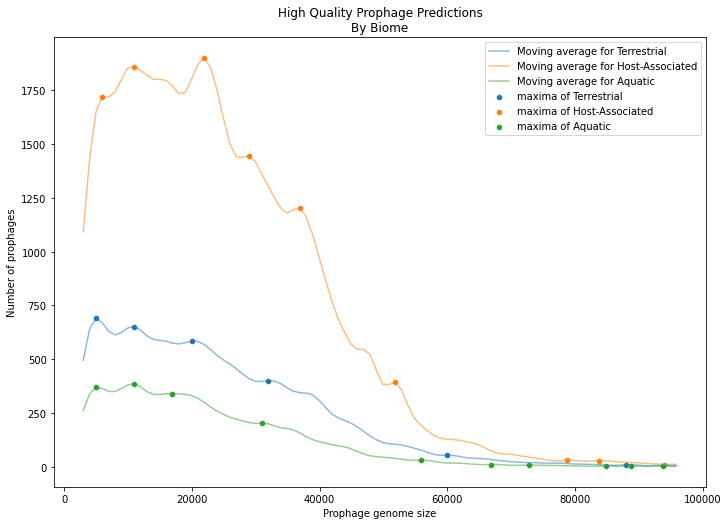

In [14]:
fig, ax = plt.subplots(1,1, figsize=(11.7,8.27))
"""
sns.lineplot(x=hf.index, y='Count', data=hf, ax=ax, alpha=0.2, label='Count')
sns.lineplot(x=hf.index, y='ma', data=hf, ax=ax, color='orange', alpha=0.5, label="Moving average")
#sns.scatterplot(x=hf.index, y='ma', data=hf, ax=ax)
sns.scatterplot(x=hf.index, y='min', color='r', data=hf, ax=ax, alpha=0.4, label='minima of phage lengths')
sns.scatterplot(x=hf.index, y='max', color='b', data=hf, ax=ax, label='maxima of phage lengths')
"""
sns.color_palette("colorblind")

for b in pd.unique(checkvcat['Biome']):
    madf = moving_averages(checkvcat[(checkvcat['Biome'] == b) & (checkvcat['contig_length'] < 100000)], 'contig_length', 100, 7)
    sns.lineplot(x=madf.index, y='ma', data=madf, ax=ax, alpha=0.5, label=f"Moving average for {b}")
    sns.scatterplot(x=madf.index, y='max', data=madf, ax=ax, label=f'maxima of {b}')
    print(f"These are the predicted maxima of phage genome lengths for {b} prophages:")
    for mx in madf[madf['max'].notnull()].index:
        print(f"{int(mx):>7,} bp",)
    print()


ax.set_xlabel('Prophage genome size')
ax.set_ylabel('Number of prophages')
ax.set_title("High Quality Prophage Predictions\nBy Biome")
